In [1]:
import json  
import pandas as pd
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
from evaluate import load
from IPython.display import display

# Load the dataset
def load_dataset(filepath):
    with open(filepath, "r") as f:
        return json.load(f)

dataset_path = "Hartshorne_test_dataset.json"
dataset = load_dataset(dataset_path)

# Load GPT-2 model and tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()

# Load HuggingFace's perplexity metric
perplexity_metric = load("perplexity", module_type="metric")

# Function to calculate perplexity using HuggingFace's evaluate library
def calculate_perplexity(sentence):
    result = perplexity_metric.compute(
        model_id="gpt2", predictions=[sentence], add_start_token=False
    )
    return result["perplexities"][0]

# Process dataset and compute perplexity for each sentence
results = []
for example in dataset:
    example_id = example["example_id"]
    question_text = example["question_text"]
    sentences = example["sentences"]

    # Compute perplexity for each sentence
    for sentence in sentences:
        sentence_text = sentence["text"]
        sub_example_id = sentence.get("sub_example_id", example_id) 
        is_grammatical = sentence.get("is_grammatical", "unknown")  # Handle cases without labels
        perplexity = calculate_perplexity(sentence_text)

        # Store the result
        results.append({
            "Example ID": example_id,
            "Sub Example ID": sub_example_id,
            "Question Text": question_text,
            "Sentence Text": sentence_text,
            "Is Grammatical": is_grammatical,
            "Perplexity": perplexity
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort results by Sub Example ID and Perplexity
results_df = results_df.sort_values(by=["Sub Example ID", "Perplexity"])

# Apply the strict rule: min_false > max_true
unexpected_cases = []

for sub_example_id, group in results_df.groupby("Sub Example ID"):
    # Sort by perplexity for each sub-example group
    group = group.sort_values(by="Perplexity")
    
    # Extract perplexities by category
    true_sentences = group[group["Is Grammatical"] == "true"]
    dialect_sentences = group[group["Is Grammatical"] == "dialect"]
    false_sentences = group[group["Is Grammatical"] == "false"]

    # Apply the rule only when all categories are present
    if (
        len(true_sentences) > 0 and len(dialect_sentences) > 0 and len(false_sentences) > 0
    ):
        # Determine min and max perplexities for each category
        max_true = true_sentences["Perplexity"].max()
        min_true = true_sentences["Perplexity"].min()
        max_dialect = dialect_sentences["Perplexity"].max()
        min_dialect = dialect_sentences["Perplexity"].min()
        max_false = false_sentences["Perplexity"].max()
        min_false = false_sentences["Perplexity"].min()

        # Check the strict ordering
        if not (
            (min_false > max_true)
        ):
            unexpected_cases.append(group)

# Combine unexpected cases into a single DataFrame
if unexpected_cases:
    unexpected_cases_df = pd.concat(unexpected_cases)
    print(f"Number of unexpected cases: {len(unexpected_cases_df)}")
    display(unexpected_cases_df[[
        "Example ID",
        "Sub Example ID",
        "Sentence Text",
        "Is Grammatical",
        "Perplexity"
    ]])
else:
    print("No unexpected cases found.")

d:\anaconda3\envs\clean_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


KeyboardInterrupt: 

### Perplexity Sorted by **Entire Dataset**

In [2]:
# Adjust display options to show the full DataFrame
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", None)  # Adjust width to prevent wrapping
pd.set_option("display.colheader_justify", "center")  # Center align column headers

# Display the DataFrame
display(results_df[[
    "Example ID",
    "Sub Example ID",
    "Sentence Text",
    "Is Grammatical",
    "Perplexity"
]].sort_values(by=['Perplexity']))  # Display the first 10 rows

,Example ID,Sub Example ID,Sentence Text,Is Grammatical,Perplexity
4,10,10c,How old are you?,dialect,11.746402
117,35,35d,He was pulled over by the police for driving 1...,true,12.938404
36,18,18c,"If he had known, he would have helped her.",true,14.126254
26,16,16a,"He broke his leg, so he is in the hospital.",dialect,15.259257
34,18,18a,"If he knew, he would have helped her.",dialect,18.251549
33,17,17d,I told Sally I was worried about the exam. She...,true,19.926399
97,32,32h,He thought he could win the game.,true,19.971149
50,22,22a,"They may be traveling, but I'm not sure.",true,21.388571
1,9,9,I won't be coming to the party after all.,true,21.591402
27,16,16b,"He broke his leg, so he is in hospital.",dialect,22.391768


### Perplexity Sorted **Per Question**

In [3]:
# Adjust display options to show the full DataFrame
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", None)  # Adjust width to prevent wrapping
pd.set_option("display.colheader_justify", "center")  # Center align column headers

# Sort the DataFrame by "Example ID" and "Perplexity"
sorted_results_df = results_df.sort_values(by=["Example ID", "Perplexity"], ascending=[True, True])

# Display the sorted DataFrame
display(sorted_results_df[[
    "Example ID",
    "Sub Example ID",
    "Sentence Text",
    "Is Grammatical",
    "Perplexity"
]])  # Display the first 20 rows

,Example ID,Sub Example ID,Sentence Text,Is Grammatical,Perplexity
4,10,10c,How old are you?,dialect,11.746402
2,10,10a,What age are you?,dialect,24.143698
3,10,10b,How age are you?,false,25.539280
5,10,10d,What old are you?,false,26.036013
7,11,11b,I will have been studying for 6 hours by dinne...,dialect,85.573051
9,11,11d,I will be studying for 6 hours by dinner time.,false,110.129013
6,11,11a,I will have studied for 6 hours by dinner time.,dialect,137.675186
8,11,11c,I will had studied for 6 hours by dinner time.,false,276.006714
13,12,12d,The people are angry.,true,48.607849
12,12,12c,The people were angry.,dialect,75.064514


### Skewness

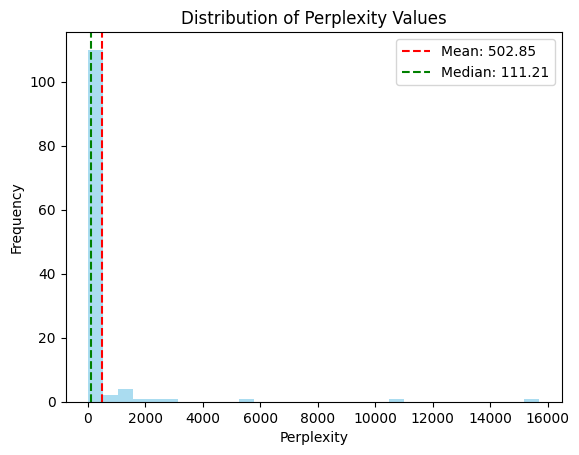

Skewness of Perplexity Data: 6.74


In [4]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Calculate skewness
skewness = stats.skew(sorted_results_df['Perplexity'])

# Visualize the distribution of perplexity values
plt.hist(sorted_results_df['Perplexity'], bins=30, color='skyblue', alpha=0.7)
plt.title('Distribution of Perplexity Values')
plt.xlabel('Perplexity')
plt.ylabel('Frequency')
plt.axvline(sorted_results_df['Perplexity'].mean(), color='red', linestyle='--', label=f'Mean: {sorted_results_df["Perplexity"].mean():.2f}')
plt.axvline(sorted_results_df['Perplexity'].median(), color='green', linestyle='--', label=f'Median: {sorted_results_df["Perplexity"].median():.2f}')
plt.legend()
plt.show()

# Print skewness value
print(f"Skewness of Perplexity Data: {skewness:.2f}")

### Log-transformation

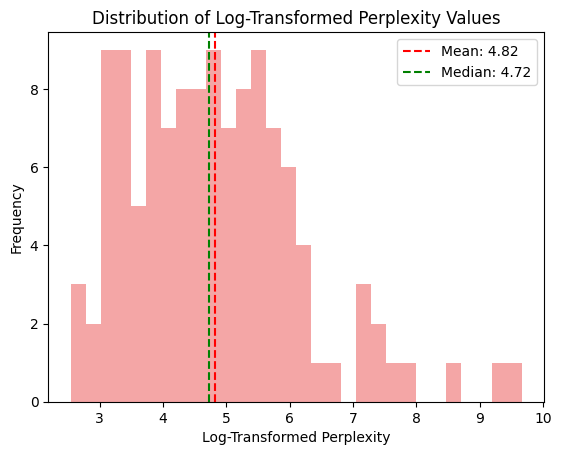

Skewness of Log-Transformed Perplexity Data: 0.90


In [5]:
import numpy as np

# Apply log transformation to perplexity values
sorted_results_df['Log_Perplexity'] = np.log1p(sorted_results_df['Perplexity'])

# Visualize the distribution of log-transformed perplexity
plt.hist(sorted_results_df['Log_Perplexity'], bins=30, color='lightcoral', alpha=0.7)
plt.title('Distribution of Log-Transformed Perplexity Values')
plt.xlabel('Log-Transformed Perplexity')
plt.ylabel('Frequency')
plt.axvline(sorted_results_df['Log_Perplexity'].mean(), color='red', linestyle='--', label=f'Mean: {sorted_results_df["Log_Perplexity"].mean():.2f}')
plt.axvline(sorted_results_df['Log_Perplexity'].median(), color='green', linestyle='--', label=f'Median: {sorted_results_df["Log_Perplexity"].median():.2f}')
plt.legend()
plt.show()

# Calculate skewness of log-transformed perplexity values
log_skewness = stats.skew(sorted_results_df['Log_Perplexity'])
print(f"Skewness of Log-Transformed Perplexity Data: {log_skewness:.2f}")

In [6]:
sorted_results_df.head()

,Example ID,Sub Example ID,Question Text,Sentence Text,Is Grammatical,Perplexity,Log_Perplexity
4,10,10c,Which of the following sentences sounds most n...,How old are you?,dialect,11.746402,2.545249
2,10,10a,Which of the following sentences sounds most n...,What age are you?,dialect,24.143698,3.224607
3,10,10b,Which of the following sentences sounds most n...,How age are you?,false,25.539280,3.278626
5,10,10d,Which of the following sentences sounds most n...,What old are you?,false,26.036013,3.297170
7,11,11b,Fill in the blank (Choose all that apply).,I will have been studying for 6 hours by dinne...,dialect,85.573051,4.460989


In [7]:
sorted_results_df.to_csv("log_sorted_results_df.csv", index=False)

## Supervised Clustering 
- Constraint: Use *exactly* 2 clusters

### **GMM**

Exact Clustering Accuracy (GMM Fixed 2 Clusters): 51.64%
Adjusted Clustering Accuracy (allowing dialect flexibility, GMM Fixed 2 Clusters): 79.51%


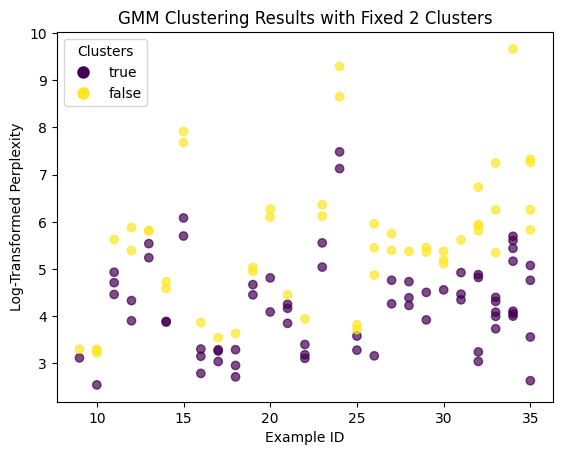

,Example ID,Sub Example ID,Sentence Text,Log_Perplexity,Is Grammatical,Predicted_Label,Is_Correct,Is_Correct_Allowing_Dialect
0,10,10c,How old are you?,2.545249,dialect,true,False,True
1,10,10a,What age are you?,3.224607,dialect,false,False,True
2,10,10b,How age are you?,3.278626,false,false,True,True
3,10,10d,What old are you?,3.297170,false,false,True,True
4,11,11b,I will have been studying for 6 hours by dinne...,4.460989,dialect,true,False,True
5,11,11d,I will be studying for 6 hours by dinner time.,4.710692,false,true,False,False
6,11,11a,I will have studied for 6 hours by dinner time.,4.932134,dialect,true,False,True
7,11,11c,I will had studied for 6 hours by dinner time.,5.624042,false,false,True,True
8,12,12d,The people are angry.,3.904149,true,true,True,True
9,12,12c,The people were angry.,4.331582,dialect,true,False,True


In [8]:
from sklearn.mixture import GaussianMixture
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Load your dataset
data = pd.read_csv("log_sorted_results_df.csv")

# Function to apply GMM clustering with 2 clusters
def apply_gmm_clustering_fixed(group):
    n_clusters = 2  # Force the number of clusters to 2
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    group['Cluster'] = gmm.fit_predict(group['Log_Perplexity'].values.reshape(-1, 1))
    
    # Assign semantic labels based on cluster means
    cluster_means = group.groupby('Cluster')['Log_Perplexity'].mean().sort_values()
    cluster_mapping = {cluster: label for cluster, label in zip(cluster_means.index, ["true", "false"])}
    group['Predicted_Label'] = group['Cluster'].map(cluster_mapping)
    return group

# Apply GMM clustering with 2 clusters per 'Example ID'
gmm_fixed_data = data.groupby('Example ID', group_keys=False).apply(apply_gmm_clustering_fixed)

# Add a comparison column for Is_Correct
gmm_fixed_data['Is_Correct'] = gmm_fixed_data['Predicted_Label'] == gmm_fixed_data['Is Grammatical']

# Add the adjusted correctness rule for Is_Correct_Allowing_Dialect
def check_correctness_allowing_dialect(row):
    if row['Is Grammatical'] == 'dialect':
        return True  # Always true for "dialect" for any predicted label
    return row['Predicted_Label'] == row['Is Grammatical']

gmm_fixed_data['Is_Correct_Allowing_Dialect'] = gmm_fixed_data.apply(check_correctness_allowing_dialect, axis=1)

# Calculate accuracies
gmm_fixed_exact = gmm_fixed_data['Is_Correct'].mean()
gmm_fixed_adjusted = gmm_fixed_data['Is_Correct_Allowing_Dialect'].mean()

print(f"Exact Clustering Accuracy (GMM Fixed 2 Clusters): {gmm_fixed_exact:.2%}")
print(f"Adjusted Clustering Accuracy (allowing dialect flexibility, GMM Fixed 2 Clusters): {gmm_fixed_adjusted:.2%}")

# Overall visualization of semantic clustering
overall_plot_data = defaultdict(list)
for example_id, group in gmm_fixed_data.groupby("Example ID"):
    overall_plot_data['Example ID'].extend([example_id] * len(group))
    overall_plot_data['Log_Perplexity'].extend(group['Log_Perplexity'])
    overall_plot_data['Predicted_Label'].extend(group['Predicted_Label'])

# Map labels to numeric for plotting
label_to_numeric = {"true": 0, "false": 1}
numeric_labels = [label_to_numeric[label] for label in overall_plot_data['Predicted_Label']]

# Plot the overall clustering results
# plt.figure(figsize=(10, 6))
scatter = plt.scatter(overall_plot_data['Example ID'], overall_plot_data['Log_Perplexity'], 
                       c=numeric_labels, cmap='viridis', alpha=0.7)

# Custom legend
legend_labels = {"true": 0, "false": 1}
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=key, 
                               markerfacecolor=scatter.cmap(scatter.norm(value)), markersize=10)
                   for key, value in legend_labels.items()]
plt.legend(handles=legend_elements, title="Clusters")

plt.title("GMM Clustering Results with Fixed 2 Clusters")
plt.xlabel("Example ID")
plt.ylabel("Log-Transformed Perplexity")
plt.show()

# Display a comparison table
comparison_table = gmm_fixed_data[['Example ID', 'Sub Example ID', 'Sentence Text', 'Log_Perplexity', 'Is Grammatical', 'Predicted_Label', 'Is_Correct', 'Is_Correct_Allowing_Dialect']]

display(comparison_table.head(10))

In [9]:
# Filter sentences where Is_Correct_Allowing_Dialect is False
false_cases = gmm_fixed_data[gmm_fixed_data['Is_Correct_Allowing_Dialect'] == False]

# Select relevant columns for display
false_cases_table = false_cases[['Example ID', 'Sub Example ID', 'Sentence Text', 'Log_Perplexity', 
                                 'Is Grammatical', 'Predicted_Label', 'Is_Correct', 'Is_Correct_Allowing_Dialect']]

# Display the table
display(false_cases_table)

,Example ID,Sub Example ID,Sentence Text,Log_Perplexity,Is Grammatical,Predicted_Label,Is_Correct,Is_Correct_Allowing_Dialect
5,11,11d,I will be studying for 6 hours by dinner time.,4.710692,false,true,False,False
13,13,13c,The man which arrived yesterday needs a wakeup...,5.537905,false,true,False,False
21,15,15a,I studies medicine.,6.081990,false,true,False,False
26,16,16d,"He broke his leg, so he is on the hospital.",3.305079,false,true,False,False
29,17,17a,I told Sally I was worried about the exam. She...,3.262417,false,true,False,False
34,18,18b,"If he had been knowing, he would have helped her.",3.291697,false,true,False,False
37,19,19c,My brother and sister were playing tennis at 1...,4.669518,false,true,False,False
41,20,20a,I said the story.,4.812082,false,true,False,False
45,21,21c,My grandmother really loved John. She left all...,4.168021,false,true,False,False
46,21,21d,My grandmother really loved John. She left all...,4.252598,false,true,False,False


### **K-means**

Exact Clustering Accuracy (K-Means, Fixed 2 Clusters): 50.82%
Adjusted Clustering Accuracy (allowing dialect flexibility, K-Means, Fixed 2 Clusters): 78.69%


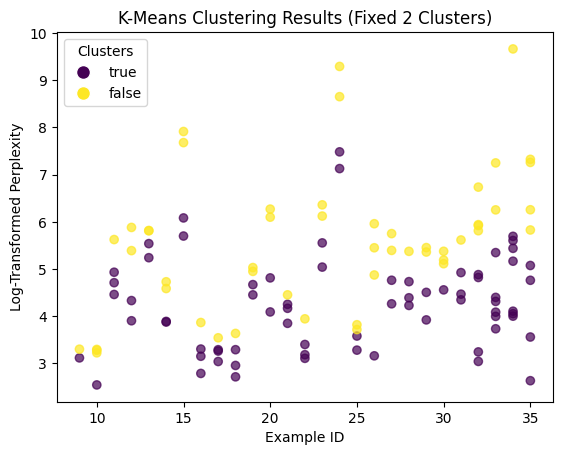

,Example ID,Sub Example ID,Sentence Text,Log_Perplexity,Is Grammatical,Predicted_Label,Is_Correct,Is_Correct_Allowing_Dialect
0,10,10c,How old are you?,2.545249,dialect,true,False,True
1,10,10a,What age are you?,3.224607,dialect,false,False,True
2,10,10b,How age are you?,3.278626,false,false,True,True
3,10,10d,What old are you?,3.297170,false,false,True,True
4,11,11b,I will have been studying for 6 hours by dinne...,4.460989,dialect,true,False,True
5,11,11d,I will be studying for 6 hours by dinner time.,4.710692,false,true,False,False
6,11,11a,I will have studied for 6 hours by dinner time.,4.932134,dialect,true,False,True
7,11,11c,I will had studied for 6 hours by dinner time.,5.624042,false,false,True,True
8,12,12d,The people are angry.,3.904149,true,true,True,True
9,12,12c,The people were angry.,4.331582,dialect,true,False,True


In [10]:
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Load your dataset
data = pd.read_csv("log_sorted_results_df.csv")

# Function to apply K-Means clustering with exactly 2 clusters
def apply_kmeans_two_clusters(group):
    n_clusters = 2  # Fixed number of clusters to 2
    
    # Fit K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    group['Cluster'] = kmeans.fit_predict(group['Log_Perplexity'].values.reshape(-1, 1))
    
    # Assign semantic labels based on cluster means
    cluster_means = group.groupby('Cluster')['Log_Perplexity'].mean().sort_values()
    cluster_mapping = {cluster: label for cluster, label in zip(cluster_means.index, ["true", "false"][:n_clusters])}
    group['Predicted_Label'] = group['Cluster'].map(cluster_mapping)
    return group

# Apply K-Means clustering with 2 clusters per 'Example ID'
kmeans_fixed_data = data.groupby('Example ID', group_keys=False).apply(apply_kmeans_two_clusters)

# Add a comparison column to check exact matches
kmeans_fixed_data['Is_Correct'] = kmeans_fixed_data['Predicted_Label'] == kmeans_fixed_data['Is Grammatical']

# Add the adjusted correctness rule for allowing dialect flexibility
def check_correctness_allowing_dialect(row):
    if row['Is Grammatical'] == 'dialect':
        return True  # Always true for "dialect"
    return row['Predicted_Label'] == row['Is Grammatical']

kmeans_fixed_data['Is_Correct_Allowing_Dialect'] = kmeans_fixed_data.apply(check_correctness_allowing_dialect, axis=1)

# Calculate accuracies
exact_accuracy = kmeans_fixed_data['Is_Correct'].mean()
adjusted_accuracy = kmeans_fixed_data['Is_Correct_Allowing_Dialect'].mean()

print(f"Exact Clustering Accuracy (K-Means, Fixed 2 Clusters): {exact_accuracy:.2%}")
print(f"Adjusted Clustering Accuracy (allowing dialect flexibility, K-Means, Fixed 2 Clusters): {adjusted_accuracy:.2%}")

# Overall visualization of semantic clustering
overall_plot_data = defaultdict(list)
for example_id, group in kmeans_fixed_data.groupby("Example ID"):
    overall_plot_data['Example ID'].extend([example_id] * len(group))
    overall_plot_data['Log_Perplexity'].extend(group['Log_Perplexity'])
    overall_plot_data['Predicted_Label'].extend(group['Predicted_Label'])

# Map labels to numeric for plotting
label_to_numeric = {"true": 0, "false": 1}
numeric_labels = [label_to_numeric[label] for label in overall_plot_data['Predicted_Label']]

# Plot the overall clustering results
#plt.figure(figsize=(10, 6))
scatter = plt.scatter(overall_plot_data['Example ID'], overall_plot_data['Log_Perplexity'], 
                       c=numeric_labels, cmap='viridis', alpha=0.7)

# Custom legend
legend_labels = {"true": 0, "false": 1}
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=key, 
                               markerfacecolor=scatter.cmap(scatter.norm(value)), markersize=10) 
                   for key, value in legend_labels.items()]
plt.legend(handles=legend_elements, title="Clusters")

plt.title("K-Means Clustering Results (Fixed 2 Clusters)")
plt.xlabel("Example ID")
plt.ylabel("Log-Transformed Perplexity")
plt.show()

# Display a comparison table
comparison_table = kmeans_fixed_data[['Example ID', 'Sub Example ID', 'Sentence Text', 'Log_Perplexity', 
                                'Is Grammatical', 'Predicted_Label', 'Is_Correct', 'Is_Correct_Allowing_Dialect']]

# Use Pandas display to show the table
display(comparison_table.head(10))

### **Hierarchical**

Exact Clustering Accuracy (Hierarchical, Fixed 2 Clusters): 56.56%
Adjusted Clustering Accuracy (allowing dialect flexibility, Hierarchical, Fixed 2 Clusters): 84.43%


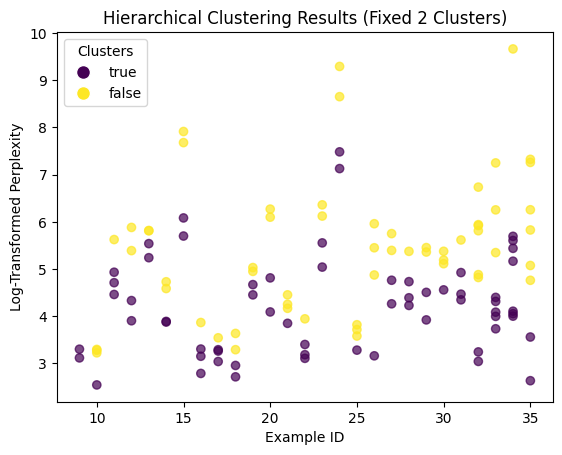

,Example ID,Sub Example ID,Sentence Text,Log_Perplexity,Is Grammatical,Predicted_Label,Is_Correct,Is_Correct_Allowing_Dialect
0,10,10c,How old are you?,2.545249,dialect,true,False,True
1,10,10a,What age are you?,3.224607,dialect,false,False,True
2,10,10b,How age are you?,3.278626,false,false,True,True
3,10,10d,What old are you?,3.297170,false,false,True,True
4,11,11b,I will have been studying for 6 hours by dinne...,4.460989,dialect,true,False,True
5,11,11d,I will be studying for 6 hours by dinner time.,4.710692,false,true,False,False
6,11,11a,I will have studied for 6 hours by dinner time.,4.932134,dialect,true,False,True
7,11,11c,I will had studied for 6 hours by dinner time.,5.624042,false,false,True,True
8,12,12d,The people are angry.,3.904149,true,true,True,True
9,12,12c,The people were angry.,4.331582,dialect,true,False,True


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
from collections import defaultdict
from sklearn.preprocessing import StandardScaler

# Load your dataset
data = pd.read_csv("log_sorted_results_df.csv")

# Function to apply Hierarchical Clustering with exactly 2 clusters
def apply_hierarchical_two_clusters(group):
    n_clusters = 2  # Fixed number of clusters to 2
    
    # Standardize the data for better clustering
    scaler = StandardScaler()
    log_perplexity_scaled = scaler.fit_transform(group['Log_Perplexity'].values.reshape(-1, 1))
    
    # Perform hierarchical clustering
    linked = linkage(log_perplexity_scaled, method='ward')
    group['Cluster'] = fcluster(linked, t=n_clusters, criterion='maxclust')
    
    # Assign semantic labels based on cluster means
    cluster_means = group.groupby('Cluster')['Log_Perplexity'].mean().sort_values()
    cluster_mapping = {cluster: label for cluster, label in zip(cluster_means.index, ["true", "false"][:n_clusters])}
    group['Predicted_Label'] = group['Cluster'].map(cluster_mapping)
    return group

# Apply Hierarchical Clustering with 2 clusters per 'Example ID'
hierarchical_fixed_data = data.groupby('Example ID', group_keys=False).apply(apply_hierarchical_two_clusters)

# Add a comparison column to check exact matches
hierarchical_fixed_data['Is_Correct'] = hierarchical_fixed_data['Predicted_Label'] == hierarchical_fixed_data['Is Grammatical']

# Add the adjusted correctness rule for allowing dialect flexibility
def check_correctness_allowing_dialect(row):
    if row['Is Grammatical'] == 'dialect':
        return True  # Always true for "dialect"
    return row['Predicted_Label'] == row['Is Grammatical']

hierarchical_fixed_data['Is_Correct_Allowing_Dialect'] = hierarchical_fixed_data.apply(check_correctness_allowing_dialect, axis=1)

# Calculate accuracies
exact_accuracy = hierarchical_fixed_data['Is_Correct'].mean()
adjusted_accuracy = hierarchical_fixed_data['Is_Correct_Allowing_Dialect'].mean()

print(f"Exact Clustering Accuracy (Hierarchical, Fixed 2 Clusters): {exact_accuracy:.2%}")
print(f"Adjusted Clustering Accuracy (allowing dialect flexibility, Hierarchical, Fixed 2 Clusters): {adjusted_accuracy:.2%}")

# Overall visualization of semantic clustering
overall_plot_data = defaultdict(list)
for example_id, group in hierarchical_fixed_data.groupby("Example ID"):
    overall_plot_data['Example ID'].extend([example_id] * len(group))
    overall_plot_data['Log_Perplexity'].extend(group['Log_Perplexity'])
    overall_plot_data['Predicted_Label'].extend(group['Predicted_Label'])

# Map labels to numeric for plotting
label_to_numeric = {"true": 0, "false": 1}
numeric_labels = [label_to_numeric[label] for label in overall_plot_data['Predicted_Label']]

# Plot the overall clustering results
scatter = plt.scatter(overall_plot_data['Example ID'], overall_plot_data['Log_Perplexity'], 
                       c=numeric_labels, cmap='viridis', alpha=0.7)

# Custom legend
legend_labels = {"true": 0, "false": 1}
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=key, 
                               markerfacecolor=scatter.cmap(scatter.norm(value)), markersize=10) 
                   for key, value in legend_labels.items()]
plt.legend(handles=legend_elements, title="Clusters")

plt.title("Hierarchical Clustering Results (Fixed 2 Clusters)")
plt.xlabel("Example ID")
plt.ylabel("Log-Transformed Perplexity")
plt.show()

# Display a comparison table
comparison_table = hierarchical_fixed_data[['Example ID', 'Sub Example ID', 'Sentence Text', 'Log_Perplexity', 
                                            'Is Grammatical', 'Predicted_Label', 'Is_Correct', 'Is_Correct_Allowing_Dialect']]

# Use Pandas display to show the table
display(comparison_table.head(10))

### **Agglomerative**
- Similar to hierarchical clustering, but computationally more efficient.

Exact Clustering Accuracy (Agglomerative, Fixed 2 Clusters): 56.56%
Adjusted Clustering Accuracy (allowing dialect flexibility, Agglomerative, Fixed 2 Clusters): 84.43%


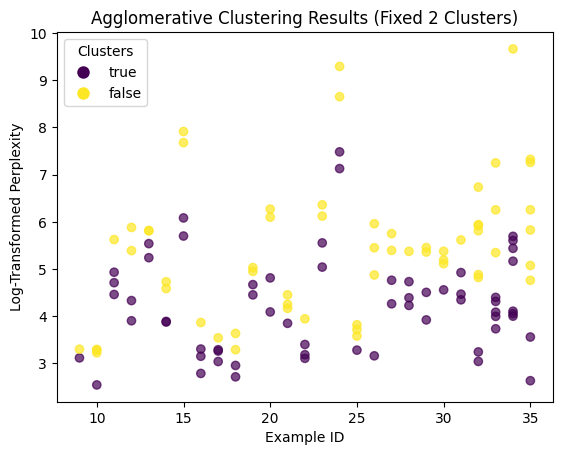

,Example ID,Sub Example ID,Sentence Text,Log_Perplexity,Is Grammatical,Predicted_Label,Is_Correct,Is_Correct_Allowing_Dialect
0,10,10c,How old are you?,2.545249,dialect,true,False,True
1,10,10a,What age are you?,3.224607,dialect,false,False,True
2,10,10b,How age are you?,3.278626,false,false,True,True
3,10,10d,What old are you?,3.297170,false,false,True,True
4,11,11b,I will have been studying for 6 hours by dinne...,4.460989,dialect,true,False,True
5,11,11d,I will be studying for 6 hours by dinner time.,4.710692,false,true,False,False
6,11,11a,I will have studied for 6 hours by dinner time.,4.932134,dialect,true,False,True
7,11,11c,I will had studied for 6 hours by dinner time.,5.624042,false,false,True,True
8,12,12d,The people are angry.,3.904149,true,true,True,True
9,12,12c,The people were angry.,4.331582,dialect,true,False,True


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

# Load your dataset
data = pd.read_csv("log_sorted_results_df.csv")

# Function to apply Agglomerative Clustering with exactly 2 clusters
def apply_agglomerative_two_clusters(group):
    n_clusters = 2  # Fixed number of clusters to 2
    
    # Standardize the data for better clustering
    scaler = StandardScaler()
    log_perplexity_scaled = scaler.fit_transform(group['Log_Perplexity'].values.reshape(-1, 1))
    
    # Perform Agglomerative Clustering
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    group['Cluster'] = agglomerative.fit_predict(log_perplexity_scaled)
    
    # Assign semantic labels based on cluster means
    cluster_means = group.groupby('Cluster')['Log_Perplexity'].mean().sort_values()
    cluster_mapping = {cluster: label for cluster, label in zip(cluster_means.index, ["true", "false"][:n_clusters])}
    group['Predicted_Label'] = group['Cluster'].map(cluster_mapping)
    return group

# Apply Agglomerative Clustering with 2 clusters per 'Example ID'
agglomerative_fixed_data = data.groupby('Example ID', group_keys=False).apply(apply_agglomerative_two_clusters)

# Add a comparison column to check exact matches
agglomerative_fixed_data['Is_Correct'] = agglomerative_fixed_data['Predicted_Label'] == agglomerative_fixed_data['Is Grammatical']

# Add the adjusted correctness rule for allowing dialect flexibility
def check_correctness_allowing_dialect(row):
    if row['Is Grammatical'] == 'dialect':
        return True  # Always true for "dialect"
    return row['Predicted_Label'] == row['Is Grammatical']

agglomerative_fixed_data['Is_Correct_Allowing_Dialect'] = agglomerative_fixed_data.apply(check_correctness_allowing_dialect, axis=1)

# Calculate accuracies
exact_accuracy = agglomerative_fixed_data['Is_Correct'].mean()
adjusted_accuracy = agglomerative_fixed_data['Is_Correct_Allowing_Dialect'].mean()

print(f"Exact Clustering Accuracy (Agglomerative, Fixed 2 Clusters): {exact_accuracy:.2%}")
print(f"Adjusted Clustering Accuracy (allowing dialect flexibility, Agglomerative, Fixed 2 Clusters): {adjusted_accuracy:.2%}")

# Overall visualization of semantic clustering
overall_plot_data = defaultdict(list)
for example_id, group in agglomerative_fixed_data.groupby("Example ID"):
    overall_plot_data['Example ID'].extend([example_id] * len(group))
    overall_plot_data['Log_Perplexity'].extend(group['Log_Perplexity'])
    overall_plot_data['Predicted_Label'].extend(group['Predicted_Label'])

# Map labels to numeric for plotting
label_to_numeric = {"true": 0, "false": 1}
numeric_labels = [label_to_numeric[label] for label in overall_plot_data['Predicted_Label']]

# Plot the overall clustering results
scatter = plt.scatter(overall_plot_data['Example ID'], overall_plot_data['Log_Perplexity'], 
                       c=numeric_labels, cmap='viridis', alpha=0.7)

# Custom legend
legend_labels = {"true": 0, "false": 1}
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=key, 
                               markerfacecolor=scatter.cmap(scatter.norm(value)), markersize=10) 
                   for key, value in legend_labels.items()]
plt.legend(handles=legend_elements, title="Clusters")

plt.title("Agglomerative Clustering Results (Fixed 2 Clusters)")
plt.xlabel("Example ID")
plt.ylabel("Log-Transformed Perplexity")
plt.show()

# Display a comparison table
comparison_table = agglomerative_fixed_data[['Example ID', 'Sub Example ID', 'Sentence Text', 'Log_Perplexity', 
                                             'Is Grammatical', 'Predicted_Label', 'Is_Correct', 'Is_Correct_Allowing_Dialect']]

# Use Pandas display to show the table
display(comparison_table.head(10))

## Unsupervised Clustering

### **GMM**

Exact Clustering Accuracy (GMM, Dynamic Clusters): 56.56%
Adjusted Clustering Accuracy (allowing dialect flexibility, GMM, Dynamic Clusters): 73.77%


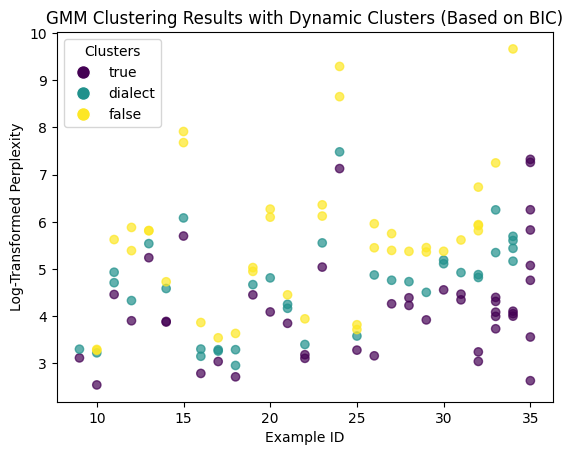

,Example ID,Sub Example ID,Sentence Text,Log_Perplexity,Is Grammatical,Predicted_Label,Is_Correct,Is_Correct_Allowing_Dialect
0,10,10c,How old are you?,2.545249,dialect,true,False,True
1,10,10a,What age are you?,3.224607,dialect,dialect,True,True
2,10,10b,How age are you?,3.278626,false,false,True,True
3,10,10d,What old are you?,3.297170,false,false,True,True
4,11,11b,I will have been studying for 6 hours by dinne...,4.460989,dialect,true,False,True
5,11,11d,I will be studying for 6 hours by dinner time.,4.710692,false,dialect,False,False
6,11,11a,I will have studied for 6 hours by dinner time.,4.932134,dialect,dialect,True,True
7,11,11c,I will had studied for 6 hours by dinner time.,5.624042,false,false,True,True
8,12,12d,The people are angry.,3.904149,true,true,True,True
9,12,12c,The people were angry.,4.331582,dialect,dialect,True,True


In [13]:
from sklearn.mixture import GaussianMixture
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Load your dataset
data = pd.read_csv("log_sorted_results_df.csv")

# Function to determine the optimal number of clusters based on BIC
def determine_gmm_clusters(group, max_clusters=3):
    # Ensure max_clusters does not exceed the number of sub-examples
    max_clusters = min(max_clusters, len(group))  # Ensure n_clusters ≤ len(group)
    bic_scores = {}
    for n_clusters in range(1, max_clusters + 1):  # Test from 1 to max_clusters
        gmm = GaussianMixture(n_components=n_clusters, random_state=42)
        gmm.fit(group['Log_Perplexity'].values.reshape(-1, 1))
        bic_scores[n_clusters] = gmm.bic(group['Log_Perplexity'].values.reshape(-1, 1))
    
    # Find the optimal number of clusters (minimum BIC)
    optimal_clusters = min(bic_scores, key=bic_scores.get)
    return optimal_clusters

# Function to apply GMM clustering with dynamically determined clusters
def apply_gmm_clustering_dynamic(group):
    # Determine the optimal number of clusters
    n_clusters = determine_gmm_clusters(group)
    
    # Fit GMM with the optimal number of clusters
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    group['Cluster'] = gmm.fit_predict(group['Log_Perplexity'].values.reshape(-1, 1))
    
    # Assign semantic labels based on cluster means
    cluster_means = group.groupby('Cluster')['Log_Perplexity'].mean().sort_values()
    cluster_mapping = {cluster: label for cluster, label in zip(cluster_means.index, ["true", "dialect", "false"][:n_clusters])}
    group['Predicted_Label'] = group['Cluster'].map(cluster_mapping)
    return group

# Apply GMM clustering with dynamically determined clusters per 'Example ID'
gmm_data = data.groupby('Example ID', group_keys=False).apply(apply_gmm_clustering_dynamic)

# Add a comparison column for exact correctness
gmm_data['Is_Correct'] = gmm_data['Predicted_Label'] == gmm_data['Is Grammatical']

# Add the adjusted correctness rule for allowing dialect flexibility
def check_correctness_allowing_dialect(row):
    if row['Is Grammatical'] == 'dialect':
        return True  # Always true for "dialect"
    return row['Predicted_Label'] == row['Is Grammatical']

gmm_data['Is_Correct_Allowing_Dialect'] = gmm_data.apply(check_correctness_allowing_dialect, axis=1)

# Calculate accuracies
exact_accuracy = gmm_data['Is_Correct'].mean()
adjusted_accuracy = gmm_data['Is_Correct_Allowing_Dialect'].mean()

print(f"Exact Clustering Accuracy (GMM, Dynamic Clusters): {exact_accuracy:.2%}")
print(f"Adjusted Clustering Accuracy (allowing dialect flexibility, GMM, Dynamic Clusters): {adjusted_accuracy:.2%}")

# Overall visualization of semantic clustering
overall_plot_data = defaultdict(list)
for example_id, group in gmm_data.groupby("Example ID"):
    overall_plot_data['Example ID'].extend([example_id] * len(group))
    overall_plot_data['Log_Perplexity'].extend(group['Log_Perplexity'])
    overall_plot_data['Predicted_Label'].extend(group['Predicted_Label'])

# Map labels to numeric for plotting
label_to_numeric = {"true": 0, "dialect": 1, "false": 2}
numeric_labels = [label_to_numeric[label] for label in overall_plot_data['Predicted_Label']]

# Plot the overall clustering results
# plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    overall_plot_data['Example ID'],
    overall_plot_data['Log_Perplexity'],
    c=numeric_labels,
    cmap='viridis',
    alpha=0.7
)

# Custom legend
legend_labels = {"true": 0, "dialect": 1, "false": 2}
legend_elements = [
    plt.Line2D(
        [0], [0], marker='o', color='w', label=key,
        markerfacecolor=scatter.cmap(scatter.norm(value)), markersize=10
    )
    for key, value in legend_labels.items()
]

plt.legend(handles=legend_elements, title="Clusters")
plt.title("GMM Clustering Results with Dynamic Clusters (Based on BIC)")
plt.xlabel("Example ID")
plt.ylabel("Log-Transformed Perplexity")
plt.show()

# Display a comparison table
comparison_table = gmm_data[['Example ID', 'Sub Example ID', 'Sentence Text', 'Log_Perplexity', 
                             'Is Grammatical', 'Predicted_Label', 'Is_Correct', 'Is_Correct_Allowing_Dialect']]

display(comparison_table)

#### Chooses 2/3 clusters

Exact Clustering Accuracy (GMM, 2 or 3 Clusters): 59.84%
Adjusted Clustering Accuracy (allowing dialect flexibility, GMM, 2 or 3 Clusters): 75.41%


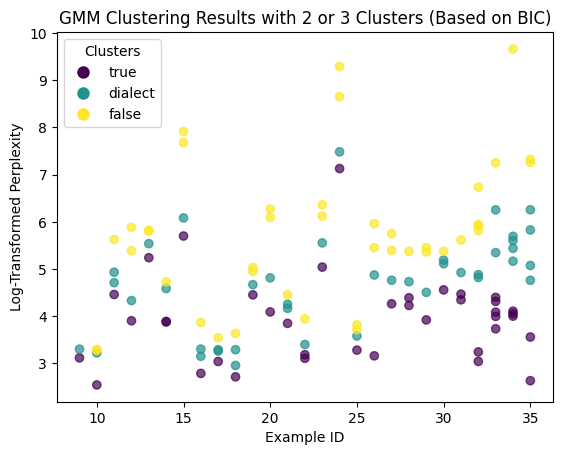

,Example ID,Sub Example ID,Sentence Text,Log_Perplexity,Is Grammatical,Predicted_Label,Is_Correct,Is_Correct_Allowing_Dialect
0,10,10c,How old are you?,2.545249,dialect,true,False,True
1,10,10a,What age are you?,3.224607,dialect,dialect,True,True
2,10,10b,How age are you?,3.278626,false,false,True,True
3,10,10d,What old are you?,3.297170,false,false,True,True
4,11,11b,I will have been studying for 6 hours by dinne...,4.460989,dialect,true,False,True


In [14]:
from sklearn.mixture import GaussianMixture
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Load your dataset
data = pd.read_csv("log_sorted_results_df.csv")

# Function to determine the optimal number of clusters (only 2 or 3 allowed) based on BIC
def determine_gmm_clusters(group, min_clusters=2, max_clusters=3):
    # Ensure max_clusters does not exceed the number of sub-examples
    max_clusters = min(max_clusters, len(group))  # Ensure n_clusters ≤ len(group)
    bic_scores = {}
    for n_clusters in range(min_clusters, max_clusters + 1):  # Test from 2 to 3 clusters
        gmm = GaussianMixture(n_components=n_clusters, random_state=42)
        gmm.fit(group['Log_Perplexity'].values.reshape(-1, 1))
        bic_scores[n_clusters] = gmm.bic(group['Log_Perplexity'].values.reshape(-1, 1))
    
    # Find the optimal number of clusters (minimum BIC)
    optimal_clusters = min(bic_scores, key=bic_scores.get)
    return optimal_clusters

# Function to apply GMM clustering with dynamically determined clusters (2 or 3)
def apply_gmm_clustering_dynamic(group):
    # Determine the optimal number of clusters
    n_clusters = determine_gmm_clusters(group)
    
    # Fit GMM with the optimal number of clusters
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    group['Cluster'] = gmm.fit_predict(group['Log_Perplexity'].values.reshape(-1, 1))
    
    # Assign semantic labels based on cluster means
    cluster_means = group.groupby('Cluster')['Log_Perplexity'].mean().sort_values()
    cluster_mapping = {cluster: label for cluster, label in zip(cluster_means.index, ["true", "dialect", "false"][:n_clusters])}
    group['Predicted_Label'] = group['Cluster'].map(cluster_mapping)
    return group

# Apply GMM clustering with dynamically determined clusters per 'Example ID'
gmm_data = data.groupby('Example ID', group_keys=False).apply(apply_gmm_clustering_dynamic)

# Add a comparison column for exact correctness
gmm_data['Is_Correct'] = gmm_data['Predicted_Label'] == gmm_data['Is Grammatical']

# Add the adjusted correctness rule for allowing dialect flexibility
def check_correctness_allowing_dialect(row):
    if row['Is Grammatical'] == 'dialect':
        return True  # Always true for "dialect"
    return row['Predicted_Label'] == row['Is Grammatical']

gmm_data['Is_Correct_Allowing_Dialect'] = gmm_data.apply(check_correctness_allowing_dialect, axis=1)

# Calculate accuracies
exact_accuracy = gmm_data['Is_Correct'].mean()
adjusted_accuracy = gmm_data['Is_Correct_Allowing_Dialect'].mean()

print(f"Exact Clustering Accuracy (GMM, 2 or 3 Clusters): {exact_accuracy:.2%}")
print(f"Adjusted Clustering Accuracy (allowing dialect flexibility, GMM, 2 or 3 Clusters): {adjusted_accuracy:.2%}")

# Overall visualization of semantic clustering
overall_plot_data = defaultdict(list)
for example_id, group in gmm_data.groupby("Example ID"):
    overall_plot_data['Example ID'].extend([example_id] * len(group))
    overall_plot_data['Log_Perplexity'].extend(group['Log_Perplexity'])
    overall_plot_data['Predicted_Label'].extend(group['Predicted_Label'])

# Map labels to numeric for plotting
label_to_numeric = {"true": 0, "dialect": 1, "false": 2}
numeric_labels = [label_to_numeric[label] for label in overall_plot_data['Predicted_Label']]

# Plot the overall clustering results
scatter = plt.scatter(
    overall_plot_data['Example ID'],
    overall_plot_data['Log_Perplexity'],
    c=numeric_labels,
    cmap='viridis',
    alpha=0.7
)

# Custom legend
legend_labels = {"true": 0, "dialect": 1, "false": 2}
legend_elements = [
    plt.Line2D(
        [0], [0], marker='o', color='w', label=key,
        markerfacecolor=scatter.cmap(scatter.norm(value)), markersize=10
    )
    for key, value in legend_labels.items()
]

plt.legend(handles=legend_elements, title="Clusters")
plt.title("GMM Clustering Results with 2 or 3 Clusters (Based on BIC)")
plt.xlabel("Example ID")
plt.ylabel("Log-Transformed Perplexity")
plt.show()

# Display a comparison table
comparison_table = gmm_data[['Example ID', 'Sub Example ID', 'Sentence Text', 'Log_Perplexity', 
                             'Is Grammatical', 'Predicted_Label', 'Is_Correct', 'Is_Correct_Allowing_Dialect']]

display(comparison_table.head())


### **DBSCAN**

In [15]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Load your dataset
data = pd.read_csv("log_sorted_results_df.csv")

# Function to evaluate DBSCAN for a specific `eps`
def evaluate_dbscan(group, eps, min_samples=2):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    group['Cluster'] = dbscan.fit_predict(group['Log_Perplexity'].values.reshape(-1, 1))
    
    # Handle cases with no clusters
    unique_clusters = set(group['Cluster']) - {-1}
    if len(unique_clusters) < 1:
        return None, None, None, group  # No valid clusters found
    
    # Assign semantic labels dynamically
    cluster_means = group[group['Cluster'] != -1].groupby('Cluster')['Log_Perplexity'].mean().sort_values()
    cluster_mapping = {cluster: label for cluster, label in zip(cluster_means.index, ["true", "dialect", "false"][:len(cluster_means)])}
    cluster_mapping[-1] = "noise"
    group['Predicted_Label'] = group['Cluster'].map(cluster_mapping)

    # Calculate accuracy metrics
    group['Is_Correct'] = group['Predicted_Label'] == group['Is Grammatical']
    def check_correctness_allowing_dialect(row):
        if row['Is Grammatical'] == 'dialect':
            return True
        return row['Predicted_Label'] == row['Is Grammatical']
    group['Is_Correct_Allowing_Dialect'] = group.apply(check_correctness_allowing_dialect, axis=1)
    
    exact_accuracy = group['Is_Correct'].mean()
    adjusted_accuracy = group['Is_Correct_Allowing_Dialect'].mean()

    # Compute silhouette score
    try:
        silhouette = silhouette_score(group['Log_Perplexity'].values.reshape(-1, 1), group['Cluster'])
    except ValueError:
        silhouette = None
    
    return exact_accuracy, adjusted_accuracy, silhouette, group

# Hyperparameter tuning for `eps`
eps_values = np.arange(0.1, 1.1, 0.1)  # Range of `eps` values to test
results = []
best_eps = None
best_metric = -1  # Track the best silhouette score

for eps in eps_values:
    exact_accuracies = []
    adjusted_accuracies = []
    silhouette_scores = []
    
    # Apply DBSCAN for each Example ID
    for _, group in data.groupby('Example ID', group_keys=False):
        exact_acc, adjusted_acc, silhouette, _ = evaluate_dbscan(group, eps)
        if exact_acc is not None:  # Valid result
            exact_accuracies.append(exact_acc)
            adjusted_accuracies.append(adjusted_acc)
            if silhouette is not None:
                silhouette_scores.append(silhouette)
    
    # Calculate average metrics for the current `eps`
    mean_exact = np.mean(exact_accuracies) if exact_accuracies else 0
    mean_adjusted = np.mean(adjusted_accuracies) if adjusted_accuracies else 0
    mean_silhouette = np.mean(silhouette_scores) if silhouette_scores else None
    
    results.append({'eps': eps, 'Exact Accuracy': mean_exact, 'Adjusted Accuracy': mean_adjusted, 'Silhouette Score': mean_silhouette})
    print(f"eps={eps:.2f}: Exact={mean_exact:.2%}, Adjusted={mean_adjusted:.2%}, Silhouette={mean_silhouette}")
    
    # Update best `eps` based on silhouette score
    if mean_silhouette is not None and mean_silhouette > best_metric:
        best_metric = mean_silhouette
        best_eps = eps

# Display results
results_df = pd.DataFrame(results)
print(f"Best eps based on silhouette score: {best_eps}")
display(results_df)

# Apply DBSCAN with the best `eps`
final_eps = best_eps or eps_values[0]
final_data = data.groupby('Example ID', group_keys=False).apply(lambda group: evaluate_dbscan(group, final_eps)[3])


eps=0.10: Exact=8.65%, Adjusted=30.77%, Silhouette=0.4345085722477173
eps=0.20: Exact=9.87%, Adjusted=34.21%, Silhouette=0.4798329233728469
eps=0.30: Exact=13.04%, Adjusted=40.76%, Silhouette=0.58534763771568
eps=0.40: Exact=16.00%, Adjusted=40.50%, Silhouette=0.6144238108417917
eps=0.50: Exact=19.23%, Adjusted=42.79%, Silhouette=0.6381210442352564
eps=0.60: Exact=20.37%, Adjusted=43.06%, Silhouette=0.6595931855190031
eps=0.70: Exact=20.37%, Adjusted=43.06%, Silhouette=0.7015395215931136
eps=0.80: Exact=19.91%, Adjusted=43.52%, Silhouette=0.6913903789943106
eps=0.90: Exact=19.91%, Adjusted=43.52%, Silhouette=0.6903577170557549
eps=1.00: Exact=23.15%, Adjusted=44.44%, Silhouette=0.6855994935948836
Best eps based on silhouette score: 0.7000000000000001


,eps,Exact Accuracy,Adjusted Accuracy,Silhouette Score
0,0.1,0.086538,0.307692,0.434509
1,0.2,0.098684,0.342105,0.479833
2,0.3,0.130435,0.407609,0.585348
3,0.4,0.160000,0.405000,0.614424
4,0.5,0.192308,0.427885,0.638121
5,0.6,0.203704,0.430556,0.659593
6,0.7,0.203704,0.430556,0.701540
7,0.8,0.199074,0.435185,0.691390
8,0.9,0.199074,0.435185,0.690358
9,1.0,0.231481,0.444444,0.685599


Final Exact Clustering Accuracy (DBSCAN with Tuned eps): 22.95%
Final Adjusted Clustering Accuracy (allowing dialect flexibility, DBSCAN with Tuned eps): 45.08%


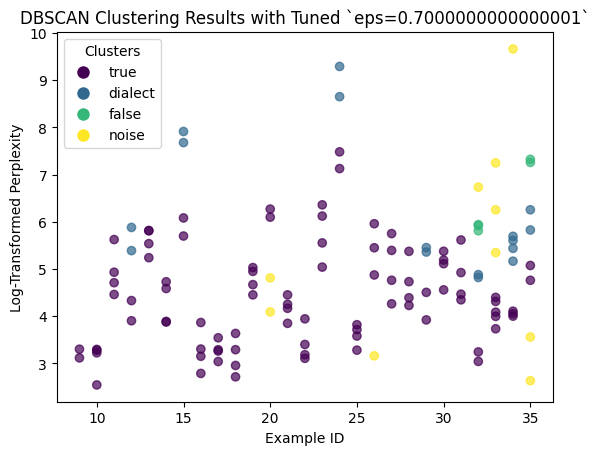

,Example ID,Sub Example ID,Sentence Text,Log_Perplexity,Is Grammatical,Predicted_Label,Is_Correct,Is_Correct_Allowing_Dialect
0,10,10c,How old are you?,2.545249,dialect,true,False,True
1,10,10a,What age are you?,3.224607,dialect,true,False,True
2,10,10b,How age are you?,3.278626,false,true,False,False
3,10,10d,What old are you?,3.297170,false,true,False,False
4,11,11b,I will have been studying for 6 hours by dinne...,4.460989,dialect,true,False,True
5,11,11d,I will be studying for 6 hours by dinner time.,4.710692,false,true,False,False
6,11,11a,I will have studied for 6 hours by dinner time.,4.932134,dialect,true,False,True
7,11,11c,I will had studied for 6 hours by dinner time.,5.624042,false,true,False,False
8,12,12d,The people are angry.,3.904149,true,true,True,True
9,12,12c,The people were angry.,4.331582,dialect,true,False,True


In [16]:
# Calculate accuracies for the final clustering results
final_data['Is_Correct'] = final_data['Predicted_Label'] == final_data['Is Grammatical']

def check_correctness_allowing_dialect(row):
    if row['Is Grammatical'] == 'dialect':
        return True  # Always true for "dialect"
    return row['Predicted_Label'] == row['Is Grammatical']

final_data['Is_Correct_Allowing_Dialect'] = final_data.apply(check_correctness_allowing_dialect, axis=1)

# Compute overall accuracy metrics
final_exact_accuracy = final_data['Is_Correct'].mean()
final_adjusted_accuracy = final_data['Is_Correct_Allowing_Dialect'].mean()

# Print accuracy metrics
print(f"Final Exact Clustering Accuracy (DBSCAN with Tuned eps): {final_exact_accuracy:.2%}")
print(f"Final Adjusted Clustering Accuracy (allowing dialect flexibility, DBSCAN with Tuned eps): {final_adjusted_accuracy:.2%}")

# Overall visualization of semantic clustering
overall_plot_data = defaultdict(list)
for example_id, group in final_data.groupby("Example ID"):
    overall_plot_data['Example ID'].extend([example_id] * len(group))
    overall_plot_data['Log_Perplexity'].extend(group['Log_Perplexity'])
    overall_plot_data['Predicted_Label'].extend(group['Predicted_Label'])

# Map labels to numeric for plotting
label_to_numeric = {"true": 0, "dialect": 1, "false": 2, "noise": 3}
numeric_labels = [label_to_numeric.get(label, 4) for label in overall_plot_data['Predicted_Label']]

# Plot the overall clustering results
#plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    overall_plot_data['Example ID'],
    overall_plot_data['Log_Perplexity'],
    c=numeric_labels,
    cmap='viridis',
    alpha=0.7
)

# Custom legend
legend_labels = {"true": 0, "dialect": 1, "false": 2, "noise": 3}
legend_elements = [
    plt.Line2D(
        [0], [0], marker='o', color='w', label=key,
        markerfacecolor=scatter.cmap(scatter.norm(value)), markersize=10
    )
    for key, value in legend_labels.items()
]

plt.legend(handles=legend_elements, title="Clusters")
plt.title(f"DBSCAN Clustering Results with Tuned `eps={final_eps}`")
plt.xlabel("Example ID")
plt.ylabel("Log-Transformed Perplexity")
plt.show()

# Display a comparison table
comparison_table = final_data[['Example ID', 'Sub Example ID', 'Sentence Text', 'Log_Perplexity', 
                               'Is Grammatical', 'Predicted_Label', 'Is_Correct', 'Is_Correct_Allowing_Dialect']]

display(comparison_table.head(10))


### **K-means**

Exact Clustering Accuracy (K-Means, Dynamic Clusters): 31.97%
Adjusted Clustering Accuracy (allowing dialect flexibility, K-Means, Dynamic Clusters): 49.18%


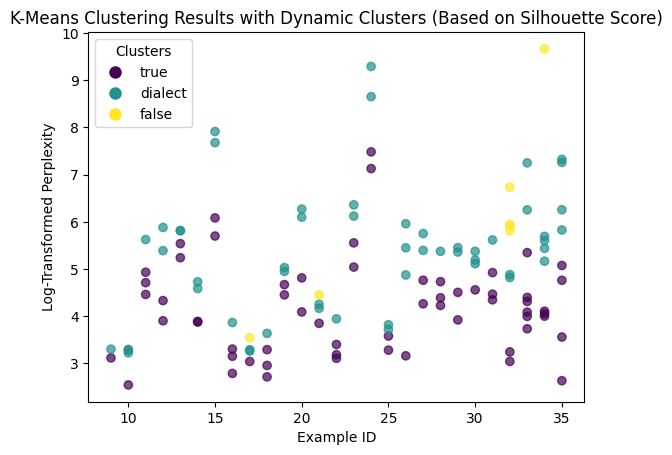

,Example ID,Sub Example ID,Sentence Text,Log_Perplexity,Is Grammatical,Predicted_Label,Is_Correct,Is_Correct_Allowing_Dialect
0,10,10c,How old are you?,2.545249,dialect,true,False,True
1,10,10a,What age are you?,3.224607,dialect,dialect,True,True
2,10,10b,How age are you?,3.278626,false,dialect,False,False
3,10,10d,What old are you?,3.297170,false,dialect,False,False
4,11,11b,I will have been studying for 6 hours by dinne...,4.460989,dialect,true,False,True
5,11,11d,I will be studying for 6 hours by dinner time.,4.710692,false,true,False,False
6,11,11a,I will have studied for 6 hours by dinner time.,4.932134,dialect,true,False,True
7,11,11c,I will had studied for 6 hours by dinner time.,5.624042,false,dialect,False,False
8,12,12d,The people are angry.,3.904149,true,true,True,True
9,12,12c,The people were angry.,4.331582,dialect,true,False,True


In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Load your dataset
data = pd.read_csv("log_sorted_results_df.csv")

# Function to determine the optimal number of clusters based on silhouette score
def determine_kmeans_clusters(group, max_clusters=3):
    n_samples = len(group)
    
    # If the group size is too small, return 2 clusters directly
    if n_samples <= 2:
        return 2
    
    silhouette_scores = {}
    for n_clusters in range(2, min(max_clusters + 1, n_samples)):  # Valid range for n_clusters
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(group['Log_Perplexity'].values.reshape(-1, 1))
        
        # Silhouette score requires at least 2 clusters
        if len(set(labels)) > 1:
            silhouette_scores[n_clusters] = silhouette_score(group['Log_Perplexity'].values.reshape(-1, 1), labels)
    
    # If no valid silhouette score is found, fallback to 2 clusters
    if silhouette_scores:
        optimal_clusters = max(silhouette_scores, key=silhouette_scores.get)
    else:
        optimal_clusters = 2  # Fallback to 2 clusters if silhouette cannot be computed
    
    return optimal_clusters

# Function to apply K-Means clustering with dynamically determined clusters
def apply_kmeans_clustering_dynamic(group):
    # Determine the optimal number of clusters
    n_clusters = determine_kmeans_clusters(group)
    
    # Fit K-Means with the optimal number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    group['Cluster'] = kmeans.fit_predict(group['Log_Perplexity'].values.reshape(-1, 1))
    
    # Assign semantic labels based on cluster means
    cluster_means = group.groupby('Cluster')['Log_Perplexity'].mean().sort_values()
    labels = ["true", "dialect", "false"]
    cluster_mapping = {cluster: label for cluster, label in zip(cluster_means.index, labels[:len(cluster_means)])}
    group['Predicted_Label'] = group['Cluster'].map(cluster_mapping)
    
    return group

# Apply K-Means clustering dynamically per 'Example ID'
kmeans_data = data.groupby('Example ID', group_keys=False).apply(apply_kmeans_clustering_dynamic)

# Add a comparison column for exact correctness
kmeans_data['Is_Correct'] = kmeans_data['Predicted_Label'] == kmeans_data['Is Grammatical']

# Add the adjusted correctness rule for allowing dialect flexibility
def check_correctness_allowing_dialect(row):
    if row['Is Grammatical'] == 'dialect':
        return True  # Always true for "dialect"
    return row['Predicted_Label'] == row['Is Grammatical']

kmeans_data['Is_Correct_Allowing_Dialect'] = kmeans_data.apply(check_correctness_allowing_dialect, axis=1)

# Calculate accuracies
exact_accuracy = kmeans_data['Is_Correct'].mean()
adjusted_accuracy = kmeans_data['Is_Correct_Allowing_Dialect'].mean()

print(f"Exact Clustering Accuracy (K-Means, Dynamic Clusters): {exact_accuracy:.2%}")
print(f"Adjusted Clustering Accuracy (allowing dialect flexibility, K-Means, Dynamic Clusters): {adjusted_accuracy:.2%}")

# Overall visualization of semantic clustering
overall_plot_data = defaultdict(list)
for example_id, group in kmeans_data.groupby("Example ID"):
    overall_plot_data['Example ID'].extend([example_id] * len(group))
    overall_plot_data['Log_Perplexity'].extend(group['Log_Perplexity'])
    overall_plot_data['Predicted_Label'].extend(group['Predicted_Label'])

# Map labels to numeric for plotting
label_to_numeric = {"true": 0, "dialect": 1, "false": 2}
numeric_labels = [label_to_numeric[label] for label in overall_plot_data['Predicted_Label']]

# Plot the overall clustering results
#plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    overall_plot_data['Example ID'],
    overall_plot_data['Log_Perplexity'],
    c=numeric_labels,
    cmap='viridis',
    alpha=0.7
)

# Custom legend
legend_labels = {"true": 0, "dialect": 1, "false": 2}
legend_elements = [
    plt.Line2D(
        [0], [0], marker='o', color='w', label=key,
        markerfacecolor=scatter.cmap(scatter.norm(value)), markersize=10
    )
    for key, value in legend_labels.items()
]

plt.legend(handles=legend_elements, title="Clusters")
plt.title("K-Means Clustering Results with Dynamic Clusters (Based on Silhouette Score)")
plt.xlabel("Example ID")
plt.ylabel("Log-Transformed Perplexity")
plt.show()

# Display a comparison table
comparison_table = kmeans_data[['Example ID', 'Sub Example ID', 'Sentence Text', 'Log_Perplexity', 
                                'Is Grammatical', 'Predicted_Label', 'Is_Correct', 'Is_Correct_Allowing_Dialect']]

display(comparison_table.head(10))

### Accuracy Summary

In [18]:
# Initialize an empty list for accuracy results
accuracy = []

# Supervised with 2 Clusters
# Retrieve accuracies for GMM 
gmm_fixed_exact = gmm_fixed_data['Is_Correct'].mean()
gmm_fixed_adjusted = gmm_fixed_data['Is_Correct_Allowing_Dialect'].mean()
accuracy.append({'Method': 'GMM (Supervised with 2 Clusters)', 
                'Exact Accuracy': f"{gmm_fixed_exact:.2%}", 
                'Adjusted Accuracy': f"{gmm_fixed_adjusted:.2%}"})

# Retrieve accuracies for K-Means 
kmeans_exact = kmeans_fixed_data['Is_Correct'].mean()
kmeans_adjusted = kmeans_fixed_data['Is_Correct_Allowing_Dialect'].mean()
accuracy.append({'Method': 'K-Means (Supervised with 2 Clusters)', 
                'Exact Accuracy': f"{kmeans_exact:.2%}", 
                'Adjusted Accuracy': f"{kmeans_adjusted:.2%}"})

# Retrieve accuracies for Hierarchical Clustering
hierarchical_exact = hierarchical_fixed_data['Is_Correct'].mean()
hierarchical_adjusted = hierarchical_fixed_data['Is_Correct_Allowing_Dialect'].mean()
accuracy.append({'Method': 'Hierarchical (Supervised with 2 Clusters)', 
                'Exact Accuracy': f"{hierarchical_exact:.2%}", 
                'Adjusted Accuracy': f"{hierarchical_adjusted:.2%}"})

# Retrieve accuracies for Agglomerative Clustering
agglomerative_exact = agglomerative_fixed_data['Is_Correct'].mean()
agglomerative_adjusted = agglomerative_fixed_data['Is_Correct_Allowing_Dialect'].mean()
accuracy.append({'Method': 'Agglomerative (Supervised with 2 Clusters)', 
                'Exact Accuracy': f"{agglomerative_exact:.2%}", 
                'Adjusted Accuracy': f"{agglomerative_adjusted:.2%}"})

# Dynamic Clusters
# Retrieve accuracies for GMM (Dynamic Clusters)
gmm_dynamic_exact = gmm_data['Is_Correct'].mean()
gmm_dynamic_adjusted = gmm_data['Is_Correct_Allowing_Dialect'].mean()
accuracy.append({'Method': 'GMM (Dynamic Clusters)', 
                'Exact Accuracy': f"{gmm_dynamic_exact:.2%}", 
                'Adjusted Accuracy': f"{gmm_dynamic_adjusted:.2%}"})

# Retrieve accuracies for DBSCAN (Tuned eps)
dbscan_exact = final_data['Is_Correct'].mean()
dbscan_adjusted = final_data['Is_Correct_Allowing_Dialect'].mean()
accuracy.append({'Method': 'DBSCAN (Tuned eps & Dynamic Clusters)', 
                'Exact Accuracy': f"{dbscan_exact:.2%}", 
                'Adjusted Accuracy': f"{dbscan_adjusted:.2%}"})

# Retrieve accuracies for K-Means (Dynamic Clusters)
kmeans_dynamic_exact = kmeans_data['Is_Correct'].mean()
kmeans_dynamic_adjusted = kmeans_data['Is_Correct_Allowing_Dialect'].mean()
accuracy.append({'Method': 'K-Means (Dynamic Clusters)', 
                'Exact Accuracy': f"{kmeans_dynamic_exact:.2%}", 
                'Adjusted Accuracy': f"{kmeans_dynamic_adjusted:.2%}"})

# Convert results to a DataFrame
accuracy_table = pd.DataFrame(accuracy)

# Display the accuracy table
display(accuracy_table)

,Method,Exact Accuracy,Adjusted Accuracy
0,GMM (Supervised with 2 Clusters),51.64%,79.51%
1,K-Means (Supervised with 2 Clusters),50.82%,78.69%
2,Hierarchical (Supervised with 2 Clusters),56.56%,84.43%
3,Agglomerative (Supervised with 2 Clusters),56.56%,84.43%
4,GMM (Dynamic Clusters),59.84%,75.41%
5,DBSCAN (Tuned eps & Dynamic Clusters),22.95%,45.08%
6,K-Means (Dynamic Clusters),31.97%,49.18%


### Further Analysis on GMM (Unsupervised)

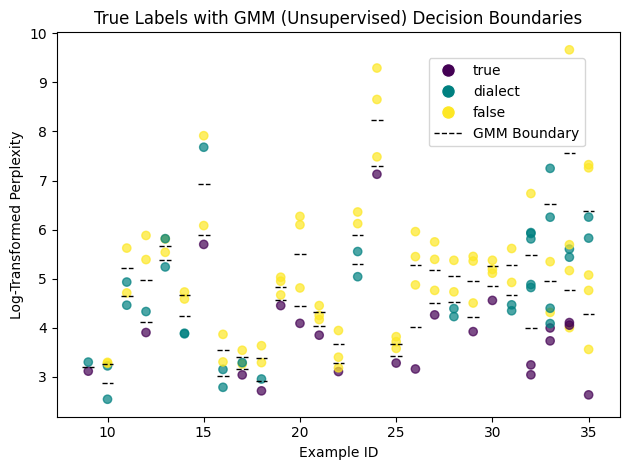

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder

# Encode true labels
label_encoder = LabelEncoder()
gmm_data['True_Label_Encoded'] = label_encoder.fit_transform(gmm_data['Is Grammatical'])

# Define a custom colormap for true labels
custom_colors = {"true": "#440154", "dialect": "teal", "false": "#FDE725FF"}  # Violet, teal, yellow

# Define the desired order of the labels
desired_order = ["true", "dialect", "false"]

# Updated method for decision boundaries
def compute_decision_boundaries_precise(group, gmm):
    # Extract means of each GMM component
    cluster_means = gmm.means_.flatten()
    cluster_means.sort()  # Ensure they are sorted for proper boundary calculation
    
    # Compute boundaries as midpoints between adjacent cluster means
    decision_boundaries = [(cluster_means[i] + cluster_means[i + 1]) / 2 for i in range(len(cluster_means) - 1)]
    return decision_boundaries

# Plot true labels with precise GMM decision boundaries for each group
#plt.figure(figsize=(12, 8))

for example_id, group in gmm_data.groupby("Example ID"):
    # Fit a GMM model dynamically for this group
    n_clusters = determine_gmm_clusters(group)
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(group['Log_Perplexity'].values.reshape(-1, 1))
    
    # Compute precise decision boundaries for this group
    boundaries = compute_decision_boundaries_precise(group, gmm)
    
    # Scatterplot of true labels for this group using custom colors
    label_colors = group['Is Grammatical'].map(custom_colors)  # Map true labels to custom colors
    plt.scatter(
        group['Example ID'], group['Log_Perplexity'],
        c=label_colors, alpha=0.7
    )
    
    # Overlay precise decision boundaries for this group
    for boundary in boundaries:
        plt.hlines(
            y=boundary,
            xmin=group['Example ID'].min() - 0.3,  # Slight offset for visibility
            xmax=group['Example ID'].max() + 0.3,
            color='black', linestyle='--', linewidth=1
        )

# Create legend elements in the desired order
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=custom_colors[label], markersize=10)
    for label in desired_order
]

# Add dashed line legend for GMM decision boundaries
legend_elements.append(
    Line2D([0], [0], color='black', linestyle='--', label="GMM Boundary", linewidth=1)
)

# Place legend inside the graph at a strategic location
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.95, 0.95), frameon=True)

# Customize plot
plt.title("True Labels with GMM (Unsupervised) Decision Boundaries")
plt.xlabel("Example ID")
plt.ylabel("Log-Transformed Perplexity")
plt.tight_layout()
plt.show()

### Further Analysis on K-Means (Supervised)

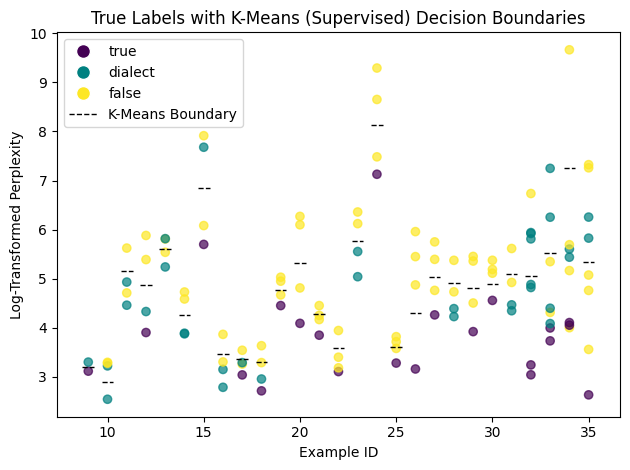

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Load your dataset
data = pd.read_csv("log_sorted_results_df.csv")

# Encode true labels
label_encoder = LabelEncoder()
data['True_Label_Encoded'] = label_encoder.fit_transform(data['Is Grammatical'])

# Define a custom colormap for true labels
custom_colors = {"true": "#440154", "dialect": "teal", "false": "#FDE725FF"}  # Violet, teal, yellow

# Define the desired order of the labels
desired_order = ["true", "dialect", "false"]

# Function to compute K-Means cluster boundaries
def compute_kmeans_boundaries(group, kmeans):
    # Extract sorted cluster centers
    cluster_centers = kmeans.cluster_centers_.flatten()
    cluster_centers.sort()
    
    # Compute boundaries as midpoints between adjacent cluster centers
    boundaries = [(cluster_centers[i] + cluster_centers[i + 1]) / 2 for i in range(len(cluster_centers) - 1)]
    return boundaries

# Apply K-Means clustering with exactly 2 clusters
def apply_kmeans_two_clusters(group):
    n_clusters = 2  # Fixed number of clusters to 2
    
    # Fit K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    group['Cluster'] = kmeans.fit_predict(group['Log_Perplexity'].values.reshape(-1, 1))
    
    # Compute boundaries for this group
    boundaries = compute_kmeans_boundaries(group, kmeans)
    
    # Assign semantic labels based on cluster means
    cluster_means = group.groupby('Cluster')['Log_Perplexity'].mean().sort_values()
    cluster_mapping = {cluster: label for cluster, label in zip(cluster_means.index, ["true", "false"][:n_clusters])}
    group['Predicted_Label'] = group['Cluster'].map(cluster_mapping)
    group['Boundaries'] = [boundaries] * len(group)  # Add boundaries to the group
    return group

# Apply K-Means clustering with 2 clusters per 'Example ID'
kmeans_fixed_data = data.groupby('Example ID', group_keys=False).apply(apply_kmeans_two_clusters)

# Scatterplot of true labels with cluster boundaries
#plt.figure(figsize=(12, 8))

for example_id, group in kmeans_fixed_data.groupby("Example ID"):
    # Scatterplot of true labels for this group using custom colors
    label_colors = group['Is Grammatical'].map(custom_colors)
    plt.scatter(
        group['Example ID'], group['Log_Perplexity'],
        c=label_colors, alpha=0.7
    )
    
    # Overlay K-Means cluster boundaries for this group
    if 'Boundaries' in group.columns and group['Boundaries'].iloc[0]:
        for boundary in group['Boundaries'].iloc[0]:
            plt.hlines(
                y=boundary,
                xmin=group['Example ID'].min() - 0.3,  # Slight offset for visibility
                xmax=group['Example ID'].max() + 0.3,
                color='black', linestyle='--', linewidth=1
            )

# Create legend elements in the desired order
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=custom_colors[label], markersize=10)
    for label in desired_order
]

# Add dashed line legend for K-Means decision boundaries
legend_elements.append(
    Line2D([0], [0], color='black', linestyle='--', label="K-Means Boundary", linewidth=1)
)

# Place legend inside the graph at a strategic location
plt.legend(handles=legend_elements, loc='upper left', frameon=True)

# Customize plot
plt.title("True Labels with K-Means (Supervised) Decision Boundaries")
plt.xlabel("Example ID")
plt.ylabel("Log-Transformed Perplexity")
plt.tight_layout()
plt.show()